# Optimization in Data Science Part 4

Referenced Textbook: https://cobweb.cs.uga.edu/~jam/scalation_guide/comp_data_science.pdf

Specifically Appendix A (Starting Page 619)

## Stochastic Gradient Descent with ADAptive Moment Estimation (ADAM)

I found this site helpful in getting the basic idea for ADAM: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

So, now that been over SGD with momentum lets tweek it one more time to impliment the full ADAM algorithm. This is pretty much the industry standard these days and is the default setting on many of the most popular data science packages so it makes sense that we would really want to understand this particular optimizer.

Some added bonuses are that this method is more efficient when working with large problem involving a lot of data or parameters and it requires less memory. Intuitively, it is a combination of SGDM and Root Mean Squared Propagation (RMSprop) algorithms.

Momentum: 

As we discussed and implimented with SDGM, this algorithm is used to accelerate the gradient descent algorithm by taking into consideration the exponentially weighted average of the gradients. Using averages makes the algorithm converge towards the minima in a faster pace.

RMSprop:

Now we are going to keep the momentum piece we used before, and added in some new logic taken from RMSprop. Root mean square prop or RMSprop is an adaptive learning algorithm that tries to improve AdaGrad. In AdaGrad the algorithm takes the cumulative sum of squared gradients, but with RMSprop and now with ADAM, it takes the exponential moving average of these squared gradients.

Now, as before we will show the associated formula need to impliment this algorithm:

![](../pics/adam/adam_eqn.jpg)


Below we will impliment adam with the "patience" stopping rule. This stopping rule basically says once our chosen preformance metric (in this case sse) stops improving for a given number of epochs we will end early. After a bit of googling, I found that 10 % of the total number of epoch is a good rule of thumb so we will start with that, but leave it as a hyperparameter we can tune. 

## Perceptron Code with ADAM

In [100]:
import numpy as np
from tensorflow.keras import activations
import matplotlib.pyplot as plt
import numpy as np
import math

### Initializing Data

In [101]:

# 10 data points: one x1 x2 y
xy = np.matrix (
[[1.0, 0.0, 0.0, 0.5],
[1.0, 0.0, 0.5, 0.3],
[1.0, 0.0, 1.0, 0.2],
[1.0, 0.5, 0.0, 0.8],
[1.0, 0.5, 0.5, 0.5],
[1.0, 0.5, 1.0, 0.3],
[1.0, 1.0, 0.0, 1.0],
[1.0, 1.0, 0.5, 0.8],
[1.0, 1.0, 1.0, 0.5],
[1.0, 1.0, 1.0, 0.6]]
)

# Taking first 3 columns of xy as matrix
x = xy[:,0:3]

# Taking last column of xy as array
y = xy[:, 3]

# Initializing B matrix
b = np.matrix (
[[0.1],
[0.2],
[0.1]]
)

### Finding SST

In [102]:
# Create a function to find SST 

def getSST (target):
    
    # Finding the sum of squares total
    y_mean = np.mean (target)
    sst = 0

    for each in target:
        sst = sst + (each - y_mean) ** 2

    # This just pulls the sst value out of the matrix to make it easier to work with
    sst = np.ndarray.item(sst)
    
    return sst

### Assigning Batches

In [103]:
# Create a function to randomly break data in batches based on batch size
# This function ensures that all data will be represented in a batch and that each batch is randomly selected

def makeBatches(data, bs):
    
   num_batch = math.ceil(data.shape[0] / bs)
    
   pos_choices = range(0, data.shape[0])
   
   rand_list = np.random.choice(pos_choices, data.shape[0], False)
   
   batch_list = np.split(rand_list, num_batch)
      
   return batch_list

### Getting Values for Batches

In [104]:
# Create a function to actually get value from original training set based on batch_list

def getBatchVals(batch):
    
    batch_vals_x = []
    batch_vals_y = []
    
    for each in batch:
        batch_vals_x.append((x[each][:]).tolist()[0])
        batch_vals_y.append((y[each][:]).tolist()[0])

    batch_vals_x = np.matrix(batch_vals_x)
        
    return batch_vals_x, batch_vals_y

### Calculating Gradient

In [105]:
# Create a function to calcuate gradients

def calcGrad (x, y, b):
    
    # Pre-activation vector
    u = np.dot(x, b)
    
    # Predicted value vector
    y_hat = activations.sigmoid(u)
    
    # Negative error vector
    e = y - y_hat
    
    # Correction vector (delta or d)
    d = - e * (y_hat * (1 - y_hat))
    
    # Gradients vector
    grad = np.transpose(x).dot(d)
    
    # Sum of squared errors
    sse = np.sum(e * e)
    
    return grad, sse

### Setting Hyperparameters

In [106]:
# Setting new_parms = b so original value will not get over written
new_parms = b

# Lists to hold values for plotting
sse_list = []
rsq_list = []
x_list = []

# Find SST
sst = getSST(y)

# Set max epochs
max_iters = 100

# Set bath size
batch_size = 5

# Set learning rate
eta = .1

# Set momentum (mean) decay hyper-parameter
# Standard value is 0.9
beta_1 = .9

# Set momentum (variance) decay hyper-parameter
# Standard value is 0.9
beta_2 = .9

# Define eps
eps = 1.0e-10

# If you want to use the patience stopping rule set useStop to True otherwise put as False
useStop = True

# Setting "patience" stopping rule parameter as a percent of total epochs
stop_rule = 0.10 
stop_val = math.ceil(stop_rule * max_iters)

# Set stopping rule sensitivity factor
# Percent difference improvement that must be made before progress is considered irrelevant
ss_ = .001

### Performing SGD with ADAM and Patience Stopping Rule

In [107]:

### Defining Terms

# p = momentum mean
# v = momentum uncentered variance
# p_hat = corrected mean
# v_hat = corrected uncentered variance 
# ts = time step
# eps = a very small value added to it to avoid division by zero

#Initializing best value as huge error
new_best = old_best = 1.0e25
inc = 0

# Outer loop handles interations for epochs
for i in range(0, max_iters):
    
    # Randomly getting list of index positions of origional data for batches
    batch_list = makeBatches(x, batch_size)

    # Resetting momentum for each iteration
    p_list = []
    v_list = []
    p_hat_list = []
    v_hat_list = []
    
    # Implimenting timestep 
    # NOTICE the counter starts at 1 not zero
    ts = 1
    
    if (useStop):
    
        # Implimenting "patience stopping rule"
        # Using rule that difference between new and old evaluation metrics must be greater than some percentage of the 
        # new evaluation metric
        if (abs(new_best - old_best) > ss_*new_best):
            # print(old_best, new_best)
            old_best = new_best
            inc = 0
        # If it does not meet the above criteria we increment the counter
        else:
            inc = inc + 1
            # print(inc)
            # If increments equal out stop value we are done an teminate early.
            if (stop_val == inc):
                print()
                print(str(stop_rule) + " % stoping rule at a " + str(ss_) + " % sensitivity factor has been reached... alogrithm exiting")
                break
    
    # Inner loop iterated through all batches of data in each epoch
    for batch in batch_list:
        
        # Getting data associated with each batch
        batch_vals_x, batch_vals_y = getBatchVals(batch)
        
        # Calculating gradients
        grad, sse = calcGrad(batch_vals_x, batch_vals_y, new_parms)
        
        # If better parameter value update new_best
        if (useStop):
            if (sse < new_best):
                new_best = sse
        
        """
        Note: Below you will notice that sometimes we subtract 1 from the time step and sometimes 
        we subtract 2. This is becuase we had to start the index at 1 so that our time step starts at one
        and we do not end up dividing by zero and we are raising the beta value to the correct time step. 
        However, since we are starting from 1 and not zero we need to subtract 1 from ts when we want the
        current values in our storage lists and subract by 2 when we want the previous
        """
        
        # Getting first values for p, v, p_hat, and v_hat
        if (ts == 1):
            
            p_list.append( (1 - beta_1) * grad )
            v_list.append( (1 - beta_2) * np.square(grad) )
            
            p_hat_list.append( p_list[ts - 1] / (1 - beta_1 ** ts) )
            v_hat_list.append( v_list[ts - 1] / (1 - beta_2 ** ts) )
            
        # Getting all other values for p, v, p_hat, and v_hat
        else:
            
            p_list.append( (1 - beta_1) * grad + beta_1 * p_list[ts - 2] )
            v_list.append( (1 - beta_2) * np.square(grad) + beta_2 * v_list[ts - 2] )
            
            p_hat_list.append( p_list[ts - 1] / (1 - beta_1 ** ts) )
            v_hat_list.append( v_list[ts - 1] / (1 - beta_2 ** ts) )
            
        # Updated weights vector
        new_parms = new_parms - eta * ( p_hat_list[ts - 1] / (np.sqrt(v_hat_list[ts - 1]) + eps) )
        
        # Incrementing time step
        ts = ts + 1

    # Appending all to lists so we can plot later
    x_list.append(i)
    sse_list.append(sse)
    rsq_list.append(1-sse/sst)

1
1e+25 0.24043067282873784
0.24043067282873784 0.14653589017869698
0.14653589017869698 0.11230036329193505
0.11230036329193505 0.05632449302753732
1
0.05632449302753732 0.05606571104015712
1
0.05606571104015712 0.05587643777307676
0.05587643777307676 0.03840561369268834
0.03840561369268834 0.022441728456088723
0.022441728456088723 0.019871774065012757
0.019871774065012757 0.011822939208069611
1
2
0.011822939208069611 0.005783462409630638
1
2
3
4
5
6
7
8
9
10

0.1 % stoping rule at a 0.001 % sensitivity factor has been reached... alogrithm exiting


### Plots

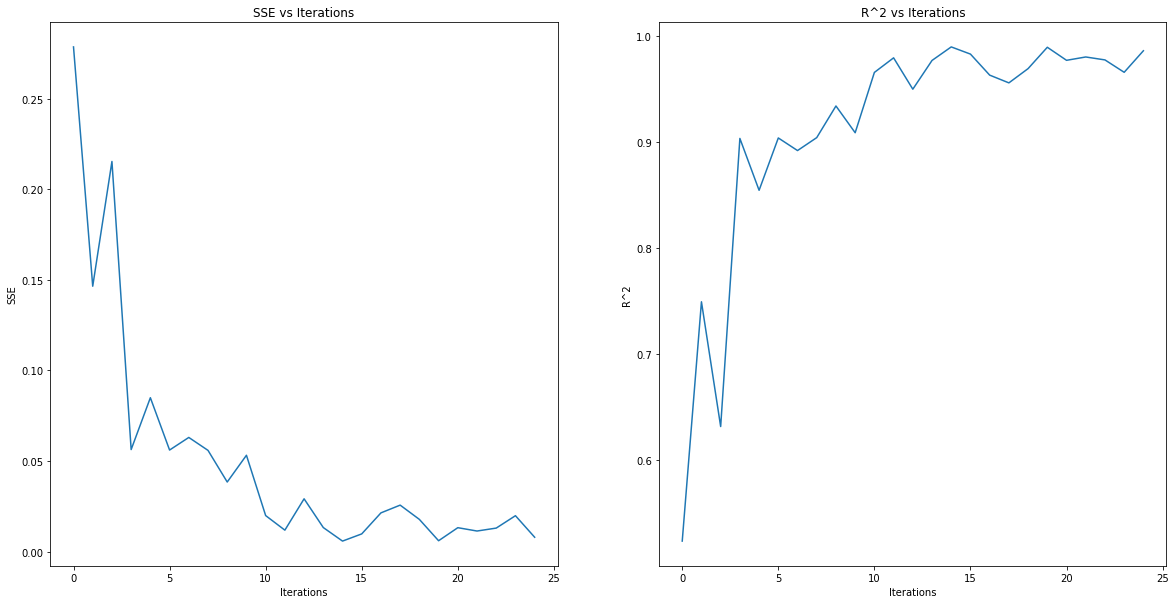

In [108]:
# To plot our findings

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(x_list, sse_list)
plt.title('SSE vs Iterations')
plt.xlabel('Iterations')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(x_list, rsq_list)
plt.title("R^2 vs Iterations")
plt.xlabel('Iterations')
plt.ylabel('R^2')


plt.show()